In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

tit = sns.load_dataset('titanic')
print(tit.shape)
tit.head()

(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


[1.1] Struktura danych
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None

          survived      pclass         age       s

/tmp/ipython-input-1063279902.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a2.set_xticklabels(['Nie', 'Tak'])


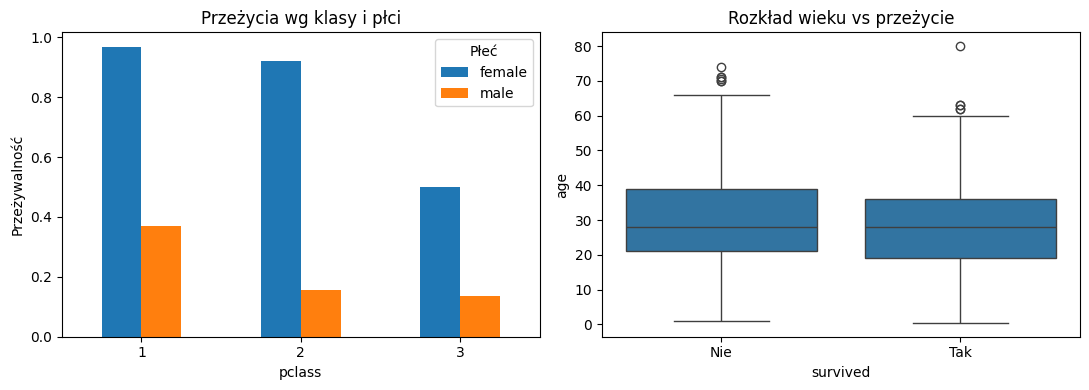

In [2]:
# 1. EKSPLORACJA DANYCH
print("[1.1] Struktura danych")
print(tit.info())
print("\n", tit.describe())

print("\n[1.2] Wartości brakujące")
nulls = tit.isnull().sum()
print(nulls[nulls > 0].sort_values(ascending=False))

print("\n[1.3] Analiza przeżywalności")
print(f"Całkowita: {tit.survived.mean():.1%}")
print("\nWg płci:", tit.groupby('sex').survived.mean().to_dict())
print("Wg klasy:", tit.groupby('pclass').survived.mean().to_dict())

print("\n[1.4] Wykres")
fig, (a1, a2) = plt.subplots(1, 2, figsize=(11, 4))
tit.groupby(['pclass', 'sex']).survived.mean().unstack().plot(kind='bar', ax=a1)
a1.set_ylabel('Przeżywalność')
a1.set_title('Przeżycia wg klasy i płci')
a1.legend(title='Płeć')
a1.tick_params(axis='x', rotation=0)
sns.boxplot(data=tit, x='survived', y='age', ax=a2)
a2.set_xticklabels(['Nie', 'Tak'])
a2.set_title('Rozkład wieku vs przeżycie')
plt.tight_layout()
plt.show()

In [9]:
# 2. PRZYGOTOWANIE DANYCH
zbedne = ['deck', 'embark_town', 'alive', 'who', 'adult_male']
tit2 = tit.drop(zbedne, axis=1).dropna(subset=['embarked']).copy()
tit2.age.fillna(tit2.age.median(), inplace=True)

tit_enc = pd.get_dummies(tit2, columns=['sex', 'embarked', 'class'], drop_first=True)

X = tit_enc.drop('survived', axis=1)
y = tit_enc['survived']
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

/tmp/ipython-input-1224512621.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tit2.age.fillna(tit2.age.median(), inplace=True)


In [4]:
# 3. TRENING MODELU
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(Xtr, ytr)

coefs = pd.Series(lr.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print("Współczynniki (posortowane wg |wartości|):")
print(coefs.round(3))

print("\nOdds Ratios:")
odds = np.exp(coefs)
print(odds.round(3))

print(f"\nInterpretacja: sex_male OR={odds['sex_male']:.3f}")
print(f"Mężczyźni mają {(1-odds['sex_male'])*100:.0f}% niższą szansę przeżycia")

Współczynniki (posortowane wg |wartości|):
sex_male       -2.476
pclass         -0.783
alone          -0.625
sibsp          -0.399
embarked_Q      0.391
class_Third    -0.369
embarked_S     -0.285
parch          -0.217
class_Second   -0.044
age            -0.035
fare            0.002
dtype: float64

Odds Ratios:
sex_male        0.084
pclass          0.457
alone           0.535
sibsp           0.671
embarked_Q      1.478
class_Third     0.691
embarked_S      0.752
parch           0.805
class_Second    0.957
age             0.966
fare            1.002
dtype: float64

Interpretacja: sex_male OR=0.084
Mężczyźni mają 92% niższą szansę przeżycia


Metryki:
  Accuracy: 0.8258
  Precision: 0.8246
  Recall: 0.6912
  F1: 0.7520
  Specificity: 0.9091


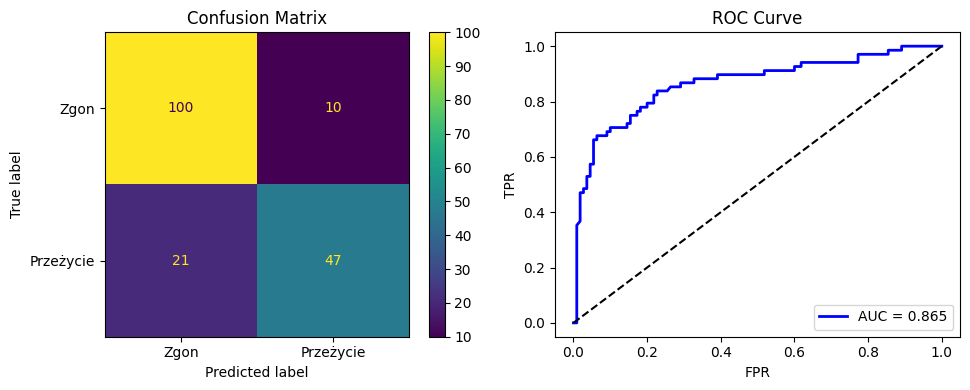

In [10]:
# 4. EWALUACJA
yhat = lr.predict(Xte)
yprob = lr.predict_proba(Xte)[:, 1]

cm = confusion_matrix(yte, yhat)
TN, FP, FN, TP = cm.ravel()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm, display_labels=['Zgon', 'Przeżycie']).plot(ax=axes[0])
axes[0].set_title('Confusion Matrix')

metryki = {
    'Accuracy': accuracy_score(yte, yhat),
    'Precision': precision_score(yte, yhat),
    'Recall': recall_score(yte, yhat),
    'F1': f1_score(yte, yhat),
    'Specificity': TN/(TN+FP)
}
print("Metryki:")
for k, v in metryki.items():
    print(f"  {k}: {v:.4f}")

fpr, tpr, _ = roc_curve(yte, yprob)
roc_auc = roc_auc_score(yte, yprob)
axes[1].plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {roc_auc:.3f}')
axes[1].plot([0,1], [0,1], 'k--')
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
plt.tight_layout()
plt.show()


In [11]:
# 5. EKSPERYMENTY
print("[5.1] Wpływ progu klasyfikacji")
for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    yt = (yprob >= t).astype(int)
    print(f"  t={t}: Prec={precision_score(yte, yt):.3f}, Rec={recall_score(yte, yt):.3f}")

print("\n[5.2] class_weight='balanced'")
lr_bal = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_bal.fit(Xtr, ytr)
yhat_bal = lr_bal.predict(Xte)
print(f"  Acc bazowy: {accuracy_score(yte, yhat):.4f} vs balanced: {accuracy_score(yte, yhat_bal):.4f}")
print(f"  Rec bazowy: {recall_score(yte, yhat):.4f} vs balanced: {recall_score(yte, yhat_bal):.4f}")

[5.1] Wpływ progu klasyfikacji
  t=0.3: Prec=0.671, Rec=0.838
  t=0.4: Prec=0.732, Rec=0.765
  t=0.5: Prec=0.825, Rec=0.691
  t=0.6: Prec=0.878, Rec=0.632
  t=0.7: Prec=0.878, Rec=0.529

[5.2] class_weight='balanced'
  Acc bazowy: 0.8258 vs balanced: 0.8034
  Rec bazowy: 0.6912 vs balanced: 0.7794


[6.1] Standaryzacja
  Mean: -0.0000, Std: 1.0000

[6.2] Wpływ C
  C= 0.001: AUC=0.8311, |coef|=0.54
  C=  0.01: AUC=0.8497, |coef|=1.93
  C=   0.1: AUC=0.8606, |coef|=3.43
  C=     1: AUC=0.8646, |coef|=3.96
  C=    10: AUC=0.8647, |coef|=4.03
  C=   100: AUC=0.8648, |coef|=4.04


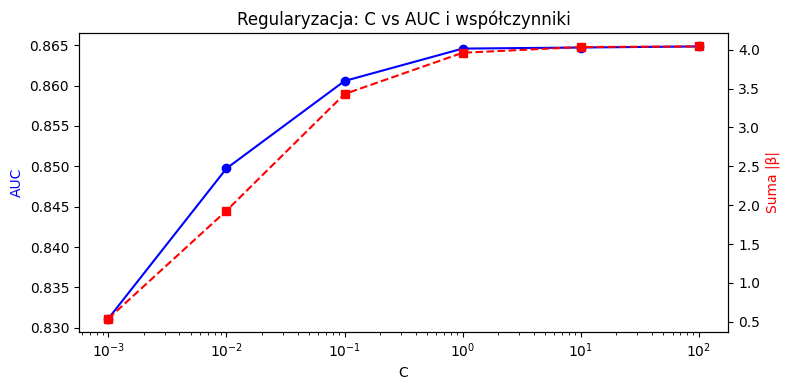


[6.3] L1 vs L2 przy C=0.1
       cecha      L2      L1
      pclass -0.4358 -0.6524
         age -0.3738 -0.2771
       sibsp -0.3228 -0.1160
       parch -0.1495 -0.0045
        fare  0.1383  0.0294
       alone -0.2454 -0.0067
    sex_male -1.1071 -1.1274
  embarked_Q  0.1033  0.0042
  embarked_S -0.1328 -0.1311
class_Second -0.0633  0.0000
 class_Third -0.3363 -0.0631

Zerowe w L1: 1
L1 zeruje współczynniki (selekcja), L2 tylko kurczy.


In [12]:
# 6. REGULARYZACJA
print("[6.1] Standaryzacja")
sc = StandardScaler()
Xtr_s = sc.fit_transform(Xtr)
Xte_s = sc.transform(Xte)
print(f"  Mean: {Xtr_s.mean():.4f}, Std: {Xtr_s.std():.4f}")

print("\n[6.2] Wpływ C")
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
aucs, sums = [], []
for c in Cs:
    m = LogisticRegression(C=c, penalty='l2', max_iter=1000)
    m.fit(Xtr_s, ytr)
    aucs.append(roc_auc_score(yte, m.predict_proba(Xte_s)[:,1]))
    sums.append(np.abs(m.coef_).sum())
    print(f"  C={c:>6}: AUC={aucs[-1]:.4f}, |coef|={sums[-1]:.2f}")

fig, ax = plt.subplots(figsize=(8, 4))
ax.semilogx(Cs, aucs, 'bo-', label='AUC')
ax.set_xlabel('C')
ax.set_ylabel('AUC', color='b')
ax2 = ax.twinx()
ax2.semilogx(Cs, sums, 'rs--', label='|β|')
ax2.set_ylabel('Suma |β|', color='r')
plt.title('Regularyzacja: C vs AUC i współczynniki')
plt.tight_layout()
plt.show()

print("\n[6.3] L1 vs L2 przy C=0.1")
l2 = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=1000).fit(Xtr_s, ytr)
l1 = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000).fit(Xtr_s, ytr)

comp = pd.DataFrame({'cecha': X.columns, 'L2': l2.coef_[0], 'L1': l1.coef_[0]}).round(4)
print(comp.to_string(index=False))
print(f"\nZerowe w L1: {(np.abs(l1.coef_[0]) < 1e-4).sum()}")
print("L1 zeruje współczynniki (selekcja), L2 tylko kurczy.")